## Source code

### Užklausos, su kuriomis galima peržiūrinėti uždavinius, jų komplektus ir sprendimus

In [1]:
import json
from IPython.display import display, Markdown
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mlc
import numpy as np
from itertools import chain, compress
from io import StringIO
import pandas as pd
import scipy.stats


def read_json(file):
    with open(file, encoding='utf-8') as fh:
        data = json.loads(fh.read())
    return data

def document_it(clusters, branches):
    clusters = read_json(clusters)
    branches = read_json(branches)
    headings = dict(zip([clusters[n][0] for n in clusters], clusters))
    docstring = ''
    for branch in branches:
        if branch in headings:
            docstring += f'\n### {headings[branch]}\n\n'
        docstring += f'* **{branch}.** {branches[branch]}\n'
    return docstring

def make_some_bank(*files, extention='.txt', show_solution=False):
    docstring = ''
    for file in files:
        heading = os.path.splitext(file)[0]
        docstring += f'\n### {heading}\n'
        bank = read_json(file + extention)
        for užduotis in bank:
            docstring += f"{užduotis}\\. {bank[užduotis]['Sąlyga']}"+'\n\n'
            if show_solution:
                docstring+=('\n\n**Sprendimas.**\n' + '\n'.join([f'* {n}' for n in bank[užduotis]["Sprendimas"]])+'\n\n')
    return docstring

def show_problem(complect, id, show_solution=True):
    problem = read_json(f'{complect}.txt')[id]
    step = '**Užduotis.**\n\n' + problem["Sąlyga"]
    if show_solution: step += ('\n\n**Sprendimas.**\n' + '\n'.join([f'* {n}' for n in problem["Sprendimas"]]))
    return step

def show_case(complect, id, which=1, show_solution=True):
    skills = read_json(f'{complect}.txt')[id]["Gebėjimai"][which-1]
    step = '**Uždavinio dalis ' + f"{which}, kurioje yra {skills['Gebėjimas']}" + '.**\n\n' + skills['Atitikmuo']
    if show_solution: step += ('\n\n**Sprendimas.**\n\n' + skills['Sprendimas'])
    return step
    
def show_skill(skill, *files, extention='.txt'):
    counter = 0
    docstring = f'### Uždaviniai[@], kuriuose yra {skill}: \n\n'
    for file in files:
        heading = os.path.splitext(file)[0]
        bank = read_json(file + extention)
        for užduotis in bank:
            for idx, gebėjimas in enumerate(bank[užduotis]['Gebėjimai']):
                if gebėjimas['Gebėjimas'] == skill:
                    counter +=1 
                    if len(bank[užduotis]['Gebėjimai'])!=1:
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {gebėjimas['Atitikmuo']}\n\n"
                    else: 
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {bank[užduotis]['Sąlyga']}\n\n"
                else: #expects to have just a list of skills without dict of descriptions - OUTDATED
                    if gebėjimas == skill:
                        counter +=1
                        docstring += f"**{heading}.{užduotis}->{idx+1}** {bank[užduotis]['Sąlyga']}\n\n"
    return docstring.replace('@', str(counter))

def get_analysis(*files, extension='.txt'):
    skills = defaultdict(list)
    for file in files:
        heading = os.path.splitext(file)[0]
        bank = read_json(file + extension)
        for užduotis in bank:
            for idx, gebėjimas in enumerate(bank[užduotis]['Gebėjimai']):
                if type(gebėjimas) is dict:
                    skills[gebėjimas['Gebėjimas']].append(f"{heading}.{užduotis}->{idx+1}")
                else:
                    skills[gebėjimas].append(f"{heading}.{užduotis}->{idx+1}")
    return skills

def check(name, problem_id, extension='.txt'):
    display(Markdown(show_problem(name, problem_id, show_solution=True)))
    problem = read_json(name + extension)
    for i in range(len(problem[problem_id]['Gebėjimai'])): 
        display(Markdown('-'*100))
        display(Markdown(show_case(name, problem_id, which=i+1, show_solution=True)))

def check_skills(name, problem_id, extension='.txt'):
    problem = read_json(name + extension)
    return [n['Gebėjimas'] for n in problem[problem_id]['Gebėjimai']]

def get_distribution(cluster_file, *files):
    analysis = get_analysis(*files)
    branch_counts = defaultdict(int)
    for branch in analysis:
        branch_counts[branch] += len(analysis[branch])
    clusters = read_json(cluster_file)
    d = dict()
    for cluster in clusters:
        bc = dict()
        for branch in clusters[cluster]:
            bc[branch] = branch_counts[branch]
            branch_counts.pop(branch)
        d[cluster] = bc
    if len(branch_counts):
        print('WARNING! Some problems contain skills that are not in clusters:\n', branch_counts)
    return d

class Skills:
    kw = dict(bbox=dict(boxstyle="square, pad=0.3", fc="w", ec="k", lw=0.72),
          arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
    cmap = plt.get_cmap("jet")
    
    def __init__(self, clusters_file, *files):
        self.distribution = get_distribution(clusters_file, *files)
        
    def set_diagram(self):
        self.inner_names = list(self.distribution.keys()) #clusters
        self.outer_names = list(chain(*[list(n.keys()) for n in self.distribution.values()])) #branches of clusters
        
        self.outer_values = np.array(list(chain(*[list(n.values()) for n in self.distribution.values()]))) #sizes of branches in each cluster
        self.inner_values = np.array([sum(n.values()) for n in self.distribution.values()]) #sizes of clusters
        
        self.inner_idx = np.flatnonzero(self.inner_values) #idx of nonzero inner values
        self.outer_idx = np.flatnonzero(self.outer_values) #idx of nonzero outer values

    def set_colors(self):
        self.set_diagram()
        marker_idx = np.cumsum([len(n) for n in self.distribution.values()])[:-1] #idx where to split flat data
        outer_spectrum = np.linspace(0, 1, len(self.outer_values))
        inner_spectrum = np.array([np.mean(n) for n in np.split(outer_spectrum, marker_idx)])        
        self.inner_colors = self.cmap(inner_spectrum)
        self.outer_colors = self.cmap(outer_spectrum)

    def flatnonzero(self):
        #remove zero pieces which is illegal
        self.inner_names = np.array(self.inner_names)[self.inner_idx]
        self.outer_names = np.array(self.outer_names)[self.outer_idx]
        self.inner_values = self.inner_values[self.inner_idx]
        self.outer_values = self.outer_values[self.outer_idx]
        self.inner_colors = self.inner_colors[self.inner_idx]
        self.outer_colors = self.outer_colors[self.outer_idx]
                                  
    def get_inner_pie(self):
        wedges, text = plt.gca().pie(self.inner_values, labels = self.inner_names, labeldistance=0.5, 
                                     radius=0.4, colors=self.inner_colors, wedgeprops=dict(width=0.2, edgecolor='k', linewidth=5), 
                                     textprops=dict(fontsize=15, fontweight='bold'))
        return wedges
    
    def add_ranges(self, intervals):
        #add mid coloring that marks knoledge
        for i in range(len(self.outer_values)):
            none = np.empty_like(self.outer_colors)
            none[:] = np.nan
            none[:,3] = np.nan
            none[i] = self.outer_colors[i]/2
            none[i,3] = 1
            plt.gca().pie(self.outer_values, radius=0.5+0.5*intervals[i][1], colors=none, 
                                wedgeprops=dict(width=0.5*(intervals[i][1] - intervals[i][0]), edgecolor='none'))
        
        
    def add_mids(self, midvalues, width=0.01):
        #add mid coloring that marks knoledge
        for i in range(len(self.outer_values)):
            #double line
            none = np.empty_like(self.outer_colors)
            none[:] = np.nan
            none[:,3] = np.nan
            none[i] = [0,0,0,1]
            plt.gca().pie(self.outer_values, radius=0.5+0.5*midvalues[i]+2*width/2, colors=none, 
                                wedgeprops=dict(width=2*width, edgecolor='none'))
            #mid line
            none = np.empty_like(self.outer_colors)
            none[:] = np.nan
            none[:,3] = np.nan
            none[i] = [1,0,1,1]
            plt.gca().pie(self.outer_values, radius=0.5+0.5*midvalues[i]+width/2, colors=none, 
                                wedgeprops=dict(width=width, edgecolor='none'))
            
    def draw_rates(self, distribution=None, Q=0.7):
        #take dict like self.distribution with values (a, t) where a=answered, t=total
        #draw rates with 70% confidence
        ranges, mids = [], []
        for a, t in distribution.values():
            p = a/t
            q = 1-p
            n = t
            v1=2*(n*q+1)
            v2=2*n*p
            v3=2*(n*p+1)
            v4=2*n*q
            CL = 1/(1 + (scipy.stats.f.ppf((1+Q)/2, v1, v2)*(q + 1/n)/p)) # CL
            CU = 1/(1+(q/(1/n+p)/scipy.stats.f.ppf((1+Q)/2, v3, v4))) # CU
            if p==0: CL=0
            if p==1: CU=1
            ranges.append((CL, CU))
            mids.append(p)
        self.add_ranges(ranges)
        self.add_mids(mids)
        
    def get_outer_pie(self):
        wedges, text = plt.gca().pie(self.outer_values, radius=1, colors=self.outer_colors, 
                                wedgeprops=dict(width=0.5, edgecolor='k'))
        return wedges
                     
    def add_labels(self, wedges):
        for i, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle, angleA=0, angleB={ang}"
            self.kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.gca().annotate(self.outer_names[i], xy=(x, y), xytext=(1.35*np.sin(x), 1.4*y),
                        horizontalalignment=horizontalalignment, fontsize=11, fontweight='bold', **self.kw)
                                  
    def plot(self, intervals=None):
        #additional data adds a piece of knowledge
        fig = plt.figure(figsize=(6, 6))
        plt.gca().set(aspect="equal")
        self.set_diagram()
        self.set_colors()
        self.flatnonzero()
        self.get_inner_pie()
        wedges = self.get_outer_pie()
        self.add_labels(wedges)
        
    
def get_data(text):
    df = pd.read_csv(StringIO(text), sep=" ")
    df.set_index(['author', 'topic','problem_id'], inplace=True)
    df1 = df[df['part']==0]
    df2 = df[df['part']!=0]
    df3 = pd.concat([df1, df2]).sort_values(by=['part'])
    df3 = df3[~df3.index.duplicated(keep='first')]
    df3['solved'][df3['part']!=0] = None
    df3 = df3.drop('part', 1)
    df3['skills'] = [tuple([n['Gebėjimas'] for n in read_json(f'{x}/{y}.txt')[str(z)]['Gebėjimai']]) for x,y,z in df3.index]
    df3['pts'] = [len(n) for n in df3['skills']]
    df4 = df3.copy()
    part = df3.loc[df3.index.repeat(df3['pts'])].groupby(['author', 'topic', 'problem_id']).cumcount() + 1
    df4 = pd.DataFrame(part, columns=['part'])
    df4['skill'] = list(chain(*df3['skills']))
    df5 = df4.merge(df2, on=['author', 'topic', 'problem_id', 'part'], how='outer')
    for n in df3[df3['solved']==True].index: 
        df5.loc[n, 'solved'] = True
    return df3, df5

def achievements(df5, df3, colors):
    vals_big = np.array([n if n == n else -1 for n in df5['solved'].values.tolist()]).astype(int)
    vals_small = np.array([n if n == n else -1 for n in df3['solved'].values.tolist()]).astype(int)
    img = vals_big[:, None]
    completed = df3['pts'].values
    shape = img.shape

    figure, ax = plt.subplots(figsize=(6,8))

    #x.set_xlabel('Activity', fontsize=13)
    #ax.set_yticklabels(list(df5['skill'].values), rotation='horizontal', fontsize=12, fontweight='bold', minor=False)
    ax.set_yticks(np.arange(-0.5+0.5, img.shape[0]+0.5, 1)) #borders between edges
    ax.set_yticklabels(list(df5['skill'].values), rotation='horizontal', fontsize=12, fontweight='bold')
    ax.set_ylim(-0.5, img.shape[0]-0.5)
    #ax.set_xticklabels(np.arange(1, img.shape[1] + 1, 1))

    #ax.set_ylabel('States', fontsize=13)
    ax.set_xticks(np.arange(0, 1, 1))
    ax.get_xaxis().set_visible(False)
    ax.set_xlim(-0.5, 0.5)
    #ax.set_yticks(np.arange(-.5, img.shape[0], 1), minor=True)
    #ax.set_yticklabels(states)

    a=0.05
    pal = {1: 'none', 0: 'red', -1: 'grey'}
    for idx, clr in enumerate(colors):
        if vals_big[idx]!=-1:
            ax.add_patch(plt.Rectangle((-0.5, -0.5+idx), 1, 1, facecolor=clr, edgecolor = pal[vals_big[idx]], hatch=r'xxx', zorder=0))
        else:
            ax.add_patch(plt.Rectangle((-0.5, -0.5+idx), 1, 1, facecolor='none', edgecolor = pal[vals_big[idx]], hatch=r'xxx'))
        
    pallete = {1: 'limegreen', 0: 'crimson', -1: 'none'}
    starts, sizes = np.cumsum(np.r_[0, df3['pts'].values[:-1]]), np.r_[df3['pts'].values]
    for start, size, solved in zip(starts, sizes, vals_small):
        ax.add_patch(plt.Rectangle((-0.5+a, start-0.5+a), 1-2*a, size-2*a, 
                                   facecolor='none', edgecolor = pallete[solved], zorder=1, lw=4, linestyle='--'))
    
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()

    
    ax.grid(which='minor', color='k')
    ax.set_title('Pasiekimai', fontsize=15, fontweight='bold')
    plt.gca().invert_yaxis()
    #plt.gca().majorticks_off()
    plt.show()

### Klasė, su kuria galima pasivaizduoti, ką sprendėme

In [2]:
import math
import matplotlib.patches as patches 
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm 
import textwrap

class Summary:
    def __init__(self, lesson_df):
        self.lesson_df = lesson_df
        
    def get_colors(self, clusters):
        skills = []
        for n in read_json(clusters).values():
            skills.extend(n)

        idx = [skills.index(n) for n in self.lesson_df['skill']]
        palette = plt.get_cmap('jet')(np.linspace(0, 1, len(skills)))
        colors = palette[idx]
        return colors
        
    def add_summary(self, colors, mode = 'abstract', height=10, width=30, 
                    fixes={'\\boxed': '', '\\sin': '\\cos'}, figsize=(6,8), wrapping=50):
        groupby = self.lesson_df.groupby(['author', 'topic', 'problem_id'], sort=False)
        chunk_sizes = groupby.size().values
        chunk_values = groupby.nth(0)['solved_fully'].values
        figure, ax = plt.subplots(figsize = figsize, dpi=100)


        ax.set_xticks(np.arange(0, width, width))
        ax.get_xaxis().set_visible(False)
        ax.set_xlim(0, width)

        a=0.05
        
        # Full rectangles
        pallete = {1: 'green', 0: 'brown'}
        yticks = []
        for start, size, solved in zip(np.cumsum(np.r_[0, chunk_sizes[:-1]]), chunk_sizes, chunk_values):
            box_position = height * (start+size/2)
            yticks.append(box_position)
            if not math.isnan(solved):
                rect = patches.Rectangle((-0.5*width, start*height+ height/2), width, size*height, facecolor='none')
                offsetbox = AuxTransformBox(ax.transData)
                offsetbox.add_artist(rect)
                ab = AnnotationBbox(offsetbox, (width/2, box_position),
                                    boxcoords="data", pad=-0.62,fontsize=4,
                                    bboxprops=dict(facecolor = "none", edgecolor=pallete[solved], 
                                              lw = 4))
                ax.add_artist(ab)
                
                
            else:
                ax.add_patch(plt.Rectangle((0, (start-0.5)*height), width, size*height, 
                                           facecolor='none', edgecolor = 'none', zorder=1, lw=4, linestyle='--'))
        
        # Partial rectangles
        for idx, clr in enumerate(colors):
            point = self.lesson_df['solved_partially'][idx]
            if math.isnan(point):
                ax.add_patch(plt.Rectangle((0, idx*height), width, height, facecolor='none', edgecolor = 'grey', hatch=r'xxx'))
            else:
                s = {True: 0.65, False: 0}[point]
                rectangle = patches.Rectangle((0, idx*height), width, height, facecolor=clr, 
                                           edgecolor = 'k', hatch=r'xxx', zorder=0)
                ax.add_patch(rectangle)
                
                #clip your colors here
                cell = (np.sin(np.linspace(0, np.pi, height)[:, np.newaxis]) * np.cos(np.linspace(-np.pi/2, np.pi/2, width))**0.5)
                col = np.c_[np.linspace(clr[0], clr[0]*s, 20),
                          np.linspace(clr[1], clr[1]*s, 20), 
                          np.linspace(clr[2], clr[2]*s, 20),
                          np.ones(20)]
                im = ax.imshow(cell, interpolation ='bicubic', cmap = ListedColormap(col), extent = (0, width, idx*height, (idx+1)*height))
                im.set_clip_path(rectangle)
              
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        
        if mode == 'abstract':
            ax.set_yticks(np.linspace(height/2, len(self.lesson_df) * height - height/2, len(self.lesson_df)))
            ax.set_yticklabels(self.lesson_df['skill'].values, rotation='horizontal', fontsize=12, fontweight='bold')

        elif mode == 'real':
            problems = []
            for author, topic, problem_id in groupby.nth(0).index:
                u = read_json(f'{author}/{topic}.txt')[str(problem_id)]['Sąlyga']
                problems.append(self.entering(self.parse_exception(u, fixes), wrapping=wrapping))

            ax.set_yticks(yticks)
            ax.set_yticklabels(problems, rotation='horizontal', fontsize=10, fontweight='bold')
        
        elif mode == 'full':
            problems = []
            for author, topic, problem_id in groupby.nth(0).index:
                u = read_json(f'{author}/{topic}.txt')[str(problem_id)]
                point_names = [self.entering(self.parse_exception(p['Atitikmuo'], fixes), wrapping=wrapping) for p in u['Gebėjimai']]
                if len(point_names) == 1:
                    problems.append(self.entering(self.parse_exception(u['Sąlyga'], fixes), wrapping=wrapping))
                else:
                    problems.extend(point_names)
                    
            ax.set_yticks(np.linspace(height/2, len(self.lesson_df) * height - height/2, len(self.lesson_df)))
            ax.set_yticklabels(problems, rotation='horizontal', fontsize=10, fontweight='bold')

        ax.set_ylim(0, len(self.lesson_df) * height)
        
        ax.set_title('Pasiekimai', fontsize=15, fontweight='bold')
        #ax.tick_params(axis='y', which='major', right=False) #might this help to extend plot
        plt.gca().invert_yaxis()
        plt.show()
    
    @staticmethod
    def parse_exception(text, fixes={}):
        for n in fixes:
            text = text.replace(n, fixes[n])
        return text
    
    @staticmethod
    def entering(text, wrapping=100):
        se = np.array([m.start() for m in re.finditer(r"(?=\$)", text)])
        if len(se):
            se = se.reshape(-1, 2) + (0, 1)
            forward = dict((text[s[0]:s[1]], str(np.random.randint(1000000000))) for s in se)
            backward = dict((forward[n], n) for n in forward)

            for n in forward:
                text = text.replace(n, forward[n])
            out_text = '\n'.join(textwrap.wrap(text, width=wrapping))
            
            for n in backward:
                out_text = out_text.replace(n, backward[n])
            return out_text
        else:
            return '\n'.join(textwrap.wrap(text, width=wrapping))
    
    
        
#Jei prireiks - uždavinių rūšiavimas pagal numerius
import re
def argsort_problems(problem_ids):
    keys = [re.match(r'(\d*)(.*)', s).groups() for s in problem_ids]
    keys = [(int(num), ord(letters)) if letters else (int(num), 0) for num, letters in keys]
    sorter = np.ravel_multi_index(np.array(keys).T, (256, 256))
    return np.argsort(sorter)

### Klasė, kuri nuskaito pamokos duomenis

In [3]:
class Lesson:
    def __init__(self, text):
        self.df = pd.read_csv(StringIO(text), sep=" ")
        self.df.set_index(['author', 'topic','problem_id'], inplace=True)

    def analyse_problems(self):
        # analysis on every problem_id or its part attempted based on metadata; no scoring
        skills, pts = [], []
        for problem in self.df.index.unique():
            author, topic, problem_id = problem
            metadata = read_json(f'{author}/{topic}.txt')
            problem_data = metadata[str(problem_id)]['Gebėjimai']
            problem_skills = [n['Gebėjimas'] for n in problem_data]
            skills.append(problem_skills)
            pts.append(len(problem_skills))
        self.problems_df = pd.DataFrame({'skills': skills, 'pts': pts}, index = self.df.index.unique())

    def analyse_points(self):
        # creates a span of point_ids for every problem_id and extracts skills from self.problems_df; no scoring
        self.analyse_problems()
        multi_idx = self.problems_df.index
        point_series = self.problems_df.loc[multi_idx.repeat(self.problems_df['pts'])].groupby(multi_idx.names).cumcount() + 1
        skill = list(chain(*self.problems_df['skills']))
        self.points_df = pd.DataFrame({'point_id': point_series.values, 'skill': skill}, index = point_series.index)

    def check_solutions(self):
        # scoring of full solutions + partial solutions; combines solution with metadata of problems & points
        self.analyse_points()
        df1 = self.df[self.df['point_id']==0]
        df2 = self.df[self.df['point_id']!=0]
        df2 = df2.reset_index().set_index(['author', 'topic', 'problem_id', 'point_id'])
        self.points_df.loc[df1.index, 'solved_fully'] = df1['solved']
        self.points_df = self.points_df.reset_index().set_index(['author', 'topic', 'problem_id','point_id'])
        self.points_df.loc[df2.index, 'solved_partially'] = df2['solved']

    def fix_typos(self):
        # typos of any of these kinds:
        # * if solved fully, all the partial solutions becomes right
        # * if any partial solution not right, it's not solved fully
        # * except the case there are not attempted partial solutions; it makes a full solution not attempted as well
        self.check_solutions()
        df = self.points_df
        df.loc[df['solved_fully'] == True, 'solved_partially'] = True
        df = df.reset_index().set_index(['author', 'topic', 'problem_id'])
        df.loc[(df['solved_partially'] == False).index, 'solved_fully'] = False
        df.loc[df['solved_partially'].isnull().index, 'solved_fully'] = np.nan
    
    def get_lesson(self):
        self.fix_typos()
        return self.points_df

## Usage

### Parodyk reikalavimų sąrašą

In [321]:
display(Markdown(document_it(r'licejus\clusters.txt', r'licejus\branches.txt')))


### Skaičiai ir skaičiavimai

* **Dalumas.** Atpažinti ir naudoti natūraliuosius skaičius. Taikyti dalumo iš 2, 3, 5, 9 ir 10 požymius. Atpažinti pirminius ir sudėtinius skaičius. Sudėtinius skaičius skaidyti pirminiais dauginamaisiais. Taikyti sąvokas: dviejų skaičių (didžiausiasis) bendrasis daliklis ar (mažiausiasis) bendrasis kartotinis.
* **$\mathbb{Z}$ ir $\mathbb{Q}$ operacijos.** Atlikti aritmetinius veiksmus su sveikaisiais ir trupmeniniais skaičiais. Taikyti šias sąvokas skaičiams: priešingas, atvirkštinis, lyginis (nelyginis), modulis. Taikyti pagrindinę proporcijos savybę
* **Procentai.** Suvokti procento sąvoką. Rasti skaičių, kai žinomi jo procentai, rasti skaičiaus procentą.
* **Šaknys ir laipsniai.** Taikyti žinias apie skaičiaus kėlimą sveikuoju laipsniu, kvadratinės ir kubinės šaknies traukimą. Atlikti nesudėtingus veiksmus su laipsniais.

### Reiškiniai, lygtys, nelygybės

* **Vienanarių ir daugianarių operacijos.** Atlikti vienanarių ir daugianarių sudėtį, atimtį ir daugybą.
* **Laipsnių taikymas reiškiniuose.** Prastinant reiškinius taikyti veiksmų su laipsniais, kurių rodiklis sveikasis skaičius, savybes.
* **Skaidymas dauginamaisiais.** Nesudėtingais atvejais skaidyti daugianarius daugikliais.
* **Greitosios daugybos formulės.** Taikyti greitosios daugybos formules.
* **Lygtys ir nelygybės.** Sudaryti ir spręsti tiesines lygtis, nelygybes. Taip pat nepilnąsias kvadratines lygtis. Jų sprendinius vaizduoti skaičių tiesėje.
* **Lygčių ir nelygybių sudarymas.** Spręsti tekstinius uždavinius sudarant lygtis, nelygybes.

### Geometrija

* **Figūrų pažinimas.** Atpažinti, pavaizduoti, apibūdinti paprasčiausias geometrines figūras.
* **Kampų rūšys.** Taikyti gretutinių, kryžminių kampų ir kampų, gautų dvi lygiagrečias tieses perkirtus trečiąja, savybes.
* **Trikampių savybės.** Taikyti žinias apie trikampį, jo aukštines, pusiaukraštines, pusiaukampines. Taikyti lygiašonio ir lygiakraščio trikampio savybes, trikampių lygumo požymius. Skaičiuoti trikampio perimetrą ir plotą.
* **Keturkampių savybės.** Taikyti keturkampių (kvadrato, stačiakampio, lygiagretainio, rombo, trapecijos) savybes ir skaičiuoti jų perimetrus bei plotus.
* **Pitagoro teorema.** Taikyti Pitagoro ir jai atvirkštinę teoremas.
* **Apskritimo ir skritulio savybės.** Taikyti žinias apie apskritimą ir skritulį. Skaičiuoti apskritimo ilgį ir skritulio plotą.
* **Erdvės geometrija.** Paprastais atvejais apskaičiuoti kubo, stačiakampio gretasienio, taisyklingosios piramidės, ritinio ir kūgio elementus.

### Kombinatorika

* **Sudėties ir daugybos taisyklės.** Taikyti kombinatorines sudėties ir daugybos taisykles, sprendžiant paprastus uždavinius. (pvz. nustatyti, kiek yra palindrominių penkiaženklių skaičių).


### Parodyk uždavinių komplektą

In [27]:
display(Markdown(make_some_bank('licejus/2017')))


### licejus/2017
1a\. Kiek yra skirtingų triženklių skaičių, kurių vienetų skaitmuo nelyginis? (1 tšk.)

1b\. Kokiu skaitmeniu baigiasi sandauga 318 dauginamųjų, kurių kiekvienas lygus 3? (1 tšk.)

1c\. Kokį dviženklį skaičių reikia pridėti prie $10^{2017}$, kad gautasis skaičius dalintųsi iš 90? (1 tšk.)

1d\. Kiek kartų padidės sandauga $ab$, jeigu dauginamąjį $a$ padidinsime 250%, o dauginamajį $b$ sumažinsime 40%? (1 tšk.)

2\. Jonas išlanksto lėktuvėlį per 3 minutes, o Zigmas tokį pat lėktuvėlį išlanksto per 4 minutes. Per kiek laiko Jonas ir Zigmas išlankstytų 14 lėktuvėlių, jei dirbtų kartu? (3tšk.)

3a\. Suprastinkite reiškinį $\displaystyle\frac{1}{2}xy^{2}\cdot (-2x^2y)^{8}$ (2tšk.)

3b\. Suprastinkite reiškinį $\displaystyle\frac{n\cdot 2^{1+n}}{2^{3-n}}$, kur $n$ - sveikasis skaičius (2tšk.)

4a\. Lygiašonės trapecijos $ABCD$ trumpesnysis pagrindas $BC$ lygus šoninėms kraštinėms. Trapecijos perimetras lygus 124 cm, o pagrindų ilgiai sutinka santykiu 13:23. Parodykite, kad trumpesnysis trapecijos pagrindas lygus 26cm. [1tšk.]

4b\. Lygiašonės trapecijos $ABCD$ trumpesnysis pagrindas $BC$ yra tokio paties ilgio kaip šoninės kraštinės ir lygus 26 cm. Trapecijos pagrindų ilgiai sutinka santykiu 13:23. Raskite šios trapecijos plotą. [3tšk.]

5\. Važiuodamas pastoviu greičiu Saulius per 15min nuvažiuoja 2 kilometrais mažiau, nei trečdalį kelio iki namų, o per 45min. - 3 kilometrais daugiau, nei pusę to paties atstumo. Apskaičiuokite Sauliaus važiavimo greitį (kilometrais per valandą) ir atstumą ligi namų [4tšk.]

6\. Žinoma, kad merginos sudarė daugiau nei 20%, bet mažiau nei 25% visų ekskursijos dalyvių skaičiaus. Raskite mažiausią galimą šios ekskursijos dalyvių skaičių [3tšk.]



### Parodyk tam tikrą uždavinį, jei reikia, su sprendimu

In [323]:
display(Markdown(show_problem('licejus/2017', '1a', show_solution=True)))

**Užduotis.**

Kiek yra skirtingų triženklių skaičių, kurių vienetų skaitmuo nelyginis? (1 tšk.)

**Sprendimas.**
* $5 \times 10 \times 10= 500$
* **Paaiškinimas:** $\begin{cases} \text{Pirmas skaitmuo: 5 variantai (1,3,5,7,9)} \\ \text{Pirmas skaitmuo: 10 variantų} \\ \text{Pirmas skaitmuo: 10 variantų} \end{cases}$

### Parodyk tam tikrą uždavinio dalį, jei reikia, su sprendimu

In [7]:
display(Markdown(show_case('licejus/2017', '2', which=1, show_solution=True)))

**Uždavinio dalis 1, kurioje yra $\mathbb{Z}$ ir $\mathbb{Q}$ operacijos.**

Jonas išlanksto lėktuvėlį per 3 minutes, o Zigmas tokį pat lėktuvėlį išlanksto per 4 minutes. Kurią dalį lėktuvėlio išlankstys per minutę kiekvienas atskirai ir kurią dirbdami kartu?

**Sprendimas.**

Jonas - $\displaystyle\frac{1}{3}$ lėktuvėlio, Zigmas - $\displaystyle\frac{1}{4}$, abu - $\displaystyle\frac{1}{3}+\frac{1}{4}=\frac{7}{12}$

### Išmesk kopijuojamą tekstą, kuris parodo rinkinį [gebėjimas -> uždavinių sąrašas]

In [324]:
get_analysis('licejus/2017')

defaultdict(list,
            {'Sudėties ir daugybos taisyklės': ['licejus/2017.1a->1'],
             'Dalumas': ['licejus/2017.1b->1', 'licejus/2017.1c->1'],
             'Procentai': ['licejus/2017.1d->1'],
             '$\\mathbb{Z}$ ir $\\mathbb{Q}$ operacijos': ['licejus/2017.2->1',
              'licejus/2017.2->2',
              'licejus/2017.2->3'],
             'Laipsnių taikymas reiškiniuose': ['licejus/2017.3a->1',
              'licejus/2017.3a->2',
              'licejus/2017.3b->1',
              'licejus/2017.3b->2']})

### Parodyk visus uždavinius, kuriems reikia tam tikro gebėjimo [veikia su klaidomis, nerodo variantų]

In [12]:
display(Markdown(show_skill('Dalumas', 'licejus/2017'))) #additional files allowed

### Uždaviniai[2], kuriuose yra Dalumas: 

**licejus/2017.1b->1** Kokiu skaitmeniu baigiasi sandauga 318 dauginamųjų, kurių kiekvienas lygus 3? (1 tšk.)

**licejus/2017.1c->1** Kokį dviženklį skaičių reikia pridėti prie $10^{2017}$, kad gautasis skaičius dalintųsi iš 90? (1 tšk.)



### Pavaizduok duoto uždavinių komplekto gebėjimų pasiskirstymą

WARNING! Some problems contain skills that are not in clusters:
 defaultdict(<class 'int'>, {'Lygčių ir nelygybių sudarymas.': 1})


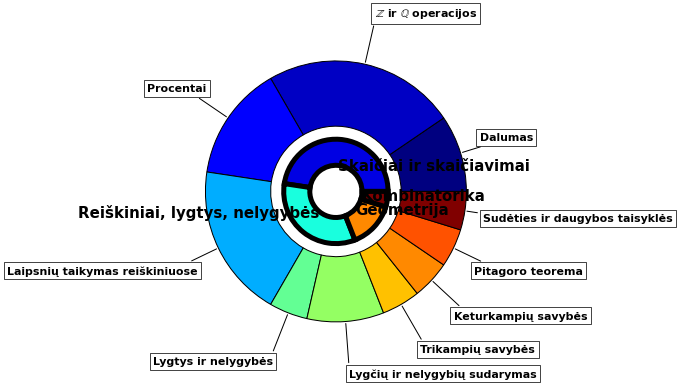

In [28]:
Skills('licejus/clusters.txt', 'licejus/2017').plot()

### Pavaizduok per pamoką spręstus uždavinius

In [33]:
display(Markdown(make_some_bank('licejus/2017')))


### licejus/2017
1a\. Kiek yra skirtingų triženklių skaičių, kurių vienetų skaitmuo nelyginis? (1 tšk.)

1b\. Kokiu skaitmeniu baigiasi sandauga 318 dauginamųjų, kurių kiekvienas lygus 3? (1 tšk.)

1c\. Kokį dviženklį skaičių reikia pridėti prie $10^{2017}$, kad gautasis skaičius dalintųsi iš 90? (1 tšk.)

1d\. Kiek kartų padidės sandauga $ab$, jeigu dauginamąjį $a$ padidinsime 250%, o dauginamajį $b$ sumažinsime 40%? (1 tšk.)

2\. Jonas išlanksto lėktuvėlį per 3 minutes, o Zigmas tokį pat lėktuvėlį išlanksto per 4 minutes. Per kiek laiko Jonas ir Zigmas išlankstytų 14 lėktuvėlių, jei dirbtų kartu? (3tšk.)

3a\. Suprastinkite reiškinį $\displaystyle \frac{1}{2}xy^2\cdot (-2x^2y)^8$ (2tšk.)

3b\. Suprastinkite reiškinį $\displaystyle \frac{n\cdot 2^{1+n}}{2^{3-n}}$, kur $n$ - sveikasis skaičius (2tšk.)



### Detaliausia įmanoma uždavinio analizė

In [333]:
check('licejus/2017', '3a') # detaliausia analizė
check_skills('licejus/2017', '3b') #tik reikiami gebėjimai

**Užduotis.**

Suprastinkite reiškinį $\displaystyle\frac{1}{2}xy^{2}\cdot (-2x^2y)^{8}$ (2tšk.)

**Sprendimas.**
* $\displaystyle\frac{1}{2}xy^2\cdot (-2x^2y)^8 = 2^{-1}xy^2 \cdot 2^8x^{16}y^8 = 2^7x^{17}y^{10}=128x^{17}y^{10}$

----------------------------------------------------------------------------------------------------

**Uždavinio dalis 1, kurioje yra Laipsnių taikymas reiškiniuose.**

$(-2x^2y)^8 = ?$

**Sprendimas.**

$(-2x^2y)^8 = 2^8x^{16}y^8=256x^{16}y^8$

----------------------------------------------------------------------------------------------------

**Uždavinio dalis 2, kurioje yra Laipsnių taikymas reiškiniuose.**

$2^{-1}xy^2 \cdot 2^8x^{16}y^8=?$

**Sprendimas.**

$2^{-1}xy^2 \cdot 2^8x^{16}y^8 = 2^7x^{17}y^{10}=128x^{17}y^{10}$

['Laipsnių taikymas reiškiniuose', 'Laipsnių taikymas reiškiniuose']

### Pamokoje spręstų uždavinių duomenų bazė

In [9]:
text = """
author topic problem_id point_id solved
licejus 2017 1a 0 False
licejus 2017 1a 1 False
licejus 2017 1b 0 False
licejus 2017 1b 1 False
licejus 2017 1c 0 False
licejus 2017 1c 1 False
licejus 2017 1d 0 False
licejus 2017 1d 1 False
licejus 2017 2 0 False
licejus 2017 2 1 False
licejus 2017 2 2 False
licejus 2017 2 3 False
licejus 2017 3a 0 False
licejus 2017 3a 1 False
licejus 2017 3a 2 False
licejus 2017 3b 0 False
licejus 2017 3b 1 False
licejus 2017 3b 2 False
""" 
Lesson(text).get_lesson()

skill  \
author  topic problem_id point_id                                            
licejus 2017  1a         1                  Sudėties ir daugybos taisyklės   
              1b         1                                         Dalumas   
              1c         1                                         Dalumas   
              1d         1                                       Procentai   
              2          1         $\mathbb{Z}$ ir $\mathbb{Q}$ operacijos   
                         2         $\mathbb{Z}$ ir $\mathbb{Q}$ operacijos   
                         3         $\mathbb{Z}$ ir $\mathbb{Q}$ operacijos   
              3a         1                  Laipsnių taikymas reiškiniuose   
                         2                  Laipsnių taikymas reiškiniuose   
              3b         1                  Laipsnių taikymas reiškiniuose   
                         2                  Laipsnių taikymas reiškiniuose   

                                   solved_fully  solved_partially  
author  topic problem_id point_id                                  
licejus 2017  1a         1                False             False  
              1b         1                False             False  
              1c         1                False             False  
              1d         1                False             False  
              2          1                False             False  
                         2                False             False  
                         3                False             False  
              3a         1                False             False  
                         2                False             False  
              3b         1                False             False  
                         2                False             False

### Trys būdai pavaizduoti pamokos darbą

In [10]:
#nepamiršti iš pradžių įrašyti pamokos duomenų į text kintamąjį
lesson_df = Lesson(text).get_lesson()
summary = Summary(lesson_df)
colors = summary.get_colors('licejus/clusters.txt')


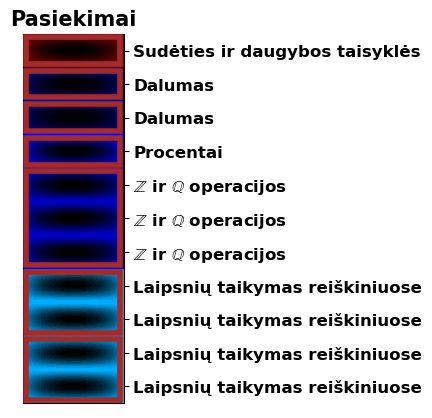

In [21]:
summary.add_summary(colors, mode = 'abstract', figsize=(1.3,9))
#summary.add_summary(colors, mode = 'real', fixes={'\\boxed': '', '\\displaystyle': ''}, figsize=(3,9))
#summary.add_summary(colors, mode = 'full', fixes={'\\boxed': '', '\\displaystyle': ''}, figsize=(3,9), wrapping=100)

In [336]:
display(Markdown(make_some_bank('licejus/2017')))


### licejus/2017
1a\. Kiek yra skirtingų triženklių skaičių, kurių vienetų skaitmuo nelyginis? (1 tšk.)

1b\. Kokiu skaitmeniu baigiasi sandauga 318 dauginamųjų, kurių kiekvienas lygus 3? (1 tšk.)

1c\. Kokį dviženklį skaičių reikia pridėti prie $10^{2017}$, kad gautasis skaičius dalintųsi iš 90? (1 tšk.)

1d\. Kiek kartų padidės sandauga $ab$, jeigu dauginamąjį $a$ padidinsime 250%, o dauginamajį $b$ sumažinsime 40%? (1 tšk.)

2\. Jonas išlanksto lėktuvėlį per 3 minutes, o Zigmas tokį pat lėktuvėlį išlanksto per 4 minutes. Per kiek laiko Jonas ir Zigmas išlankstytų 14 lėktuvėlių, jei dirbtų kartu? (3tšk.)

3a\. Suprastinkite reiškinį $\displaystyle\frac{1}{2}xy^{2}\cdot (-2x^2y)^{8}$ (2tšk.)

3b\. Suprastinkite reiškinį $\displaystyle\frac{n\cdot 2^{1+n}}{2^{3-n}}$, kur $n$ - sveikasis skaičius (2tšk.)



In [29]:
#display(Markdown(show_case('licejus/2017', '4a', which=1, show_solution=True)))
#display(Markdown(show_problem('licejus/2017', '2', show_solution=True)))
#check('licejus/2017', '2') # detaliausia analizė
#check_skills('simonas/susipažinimas', '8') #tik reikiami gebėjimai

**Uždavinio dalis 1, kurioje yra Lygčių ir nelygybių sudarymas..**



**Sprendimas.**

